In [1]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

from sklearn.metrics import f1_score

import time
from tqdm import tqdm
import nltk

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
MAX_LEN = 30
BATCH = 16
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
EPOCHS = 10
LEARNING_RATE = 0.01
THRESHOLD = 0.2
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 0.1
MODE='min'
PATIENCE=2
FACTOR=0.5
VERBOSE=True

In [3]:
df_data = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [4]:
df_data.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
0,look around you,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,say hello to your competition,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,five of you will crack under the pressure,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,two of you will be asked to leave,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
columns = ['Utterances', 'sentiment_0', 'sentiment_1', 'sentiment_2']
multi_columns = df_data[columns].copy()
multi_columns.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2
0,look around you,0,0,1
1,say hello to your competition,0,0,1
2,eight of you will switch to an easier specialty,0,0,1
3,five of you will crack under the pressure,0,0,1
4,two of you will be asked to leave,0,0,1


In [6]:
df_data['label'] = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].idxmax(axis=1)
df_data['label'] = df_data['label'].apply(lambda x: int(x.split('_')[1]))
df_data = df_data[['Utterances', 'label']]
df_data = df_data[df_data['label'] != 2]
df_data

,Utterances,label
17,the nazi? me too,1
18,you got the nazi? so did i,1
19,"at least we'll be tortured together, right?",1
20,i'm george o'malley,1
21,"uh, we met at the mixer. you had on a black dr...",1
...,...,...
20012,"oh, that's right, you're a woman and you need ...",0
20013,i'll try again,0
20014,"please, pam, reconsider and have a bagel",0
20015,i have an early lunch,0


In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['label'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }


In [8]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [9]:
print(f"Original train size: {df_data.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (8167, 2)
Validation size: (1226, 2), Test size: (1225, 2)


In [10]:
label_frequencies = df_train['label'].value_counts()
label_frequencies_percent = df_train['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
1    54.706088
0    45.293912
Name: proportion, dtype: float64
label
1    3127
0    2589
Name: count, dtype: int64


In [11]:
class_distribution = df_train['label'].value_counts(normalize=True)
print(class_distribution)

label
1    0.547061
0    0.452939
Name: proportion, dtype: float64


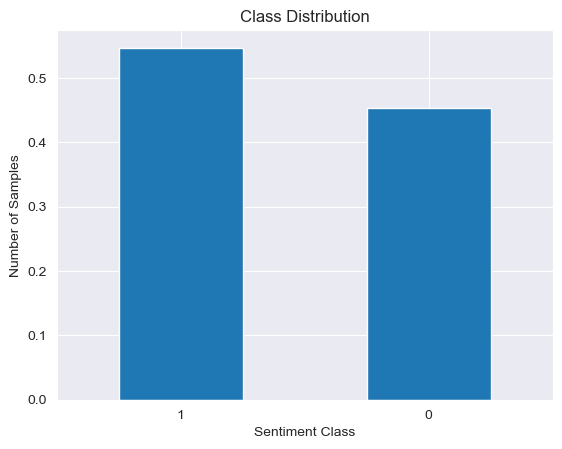

In [12]:
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [13]:
target_list = list(df_data.columns)
target_list = target_list[1:]
target_list

['label']

In [14]:
print(BertModel)

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [15]:
class BERTBinarySentimentClassificationClass(nn.Module):
    def __init__(self, bert_model):
        super(BERTBinarySentimentClassificationClass, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classification (1 output)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Forward pass przez BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output  # Weź ukrytą reprezentację z [CLS]
        dropout_output = self.dropout(pooled_output)
        return self.out(dropout_output)


In [16]:
#model_path = 'best_model_state.bin'
bert_model = BertModel.from_pretrained("bert-base-uncased")
model = BERTBinarySentimentClassificationClass(bert_model)
#model.load_state_dict(torch.load(model_path))
model.to(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [18]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [19]:
data = next(iter(train_data_loader))
outputs = model(data["input_ids"], attention_mask=data["attention_mask"])
print(outputs)


tensor([[ 0.0370],
        [-0.2933],
        [-0.0473],
        [-0.2538],
        [-0.3765],
        [-0.1320],
        [ 0.0630],
        [-0.1006],
        [-0.3500],
        [-0.0839],
        [ 0.1659],
        [-0.4285],
        [-0.3202],
        [-0.0064],
        [-0.0599],
        [-0.1669]], grad_fn=<AddmmBackward0>)


In [20]:
test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

In [22]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs.squeeze(), targets.float())


In [23]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup
#EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def train_model(training_loader, model, optimizer):
    """
    Trenuje model na danych treningowych i zwraca model, dokładność, średni loss oraz F1-score.

    Args:
        training_loader (DataLoader): DataLoader z danymi treningowymi.
        model (torch.nn.Module): Model do trenowania.
        optimizer (torch.optim.Optimizer): Optymalizator do aktualizacji wag modelu.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.

    Returns:
        model (torch.nn.Module): Wytrenowany model.
        train_accuracy (float): Dokładność modelu na zbiorze treningowym.
        avg_loss (float): Średnia wartość funkcji strat.
        train_f1 (float): F1-score (binary) na zbiorze treningowym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.squeeze(-1)  # Dopasowanie wymiarów do binary classification (1D)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        loop.set_postfix(batch_loss=loss.item())

    train_f1 = f1_score(all_labels, all_preds, average='binary')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1


In [26]:
def eval_model(validation_loader, model, epoch):
    """
    Ewaluacja modelu na danych walidacyjnych.

    Args:
        validation_loader (DataLoader): DataLoader z danymi walidacyjnymi.
        model (torch.nn.Module): Model do oceny.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.
        epoch (int): Aktualny numer epoki do logowania w TensorBoard.

    Returns:
        val_accuracy (float): Dokładność modelu na zbiorze walidacyjnym.
        avg_loss (float): Średnia wartość funkcji strat na zbiorze walidacyjnym.
        val_f1 (float): F1-score (binary) na zbiorze walidacyjnym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Ustaw model w tryb ewaluacyjny
    model.eval()

    # Wyłącz gradienty dla ewaluacji
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

            outputs = model(ids, mask, token_type_ids)
            outputs = outputs.squeeze(-1)
            
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='binary')

    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1


In [27]:
history = defaultdict(list)
best_f1 = 0
patience_counter = 0


for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Sprawdzenie najlepszej F1 i zapisanie modelu
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_binary_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    scheduler.step(val_loss)  # Tuning LR

writer.close()


Epoch 1/10


  0%|          | 0/358 [00:00<?, ?it/s]

Train loss 0.9919 | Train accuracy 0.5031 | Train F1 0.5483
Val loss 0.6924 | Val accuracy 0.5237 | Val F1 0.6874
Saved new best model.
Epoch 2/10


  0%|          | 0/358 [00:00<?, ?it/s]

Train loss 0.9734 | Train accuracy 0.5068 | Train F1 0.5498
Val loss 0.7172 | Val accuracy 0.5237 | Val F1 0.6874
Epoch 3/10


  0%|          | 0/358 [00:00<?, ?it/s]

Train loss 0.8994 | Train accuracy 0.5159 | Train F1 0.5683
Val loss 1.8919 | Val accuracy 0.5237 | Val F1 0.6874
Epoch 4/10


  0%|          | 0/358 [00:00<?, ?it/s]

Train loss 1.0567 | Train accuracy 0.5028 | Train F1 0.5505
Val loss 1.2763 | Val accuracy 0.5237 | Val F1 0.6874
Epoch 5/10


  0%|          | 0/358 [00:00<?, ?it/s]

KeyboardInterrupt: 